Let's have a look on how to use the **sansSouci.python** python package with 3D fMRI data. To do so, we will also use the **nilearn** package.


If nilearn is not installed, please type 'pip install nilearn'


### Load and pre-treat data

In [1]:

#1) IMPORTS
#standard imports
import numpy as np
import matplotlib.pyplot as plt

#nilearn imports
import nilearn
from nilearn import datasets
from nilearn.input_data import NiftiMasker
from nilearn.image import get_data
from nilearn import plotting

#sanssouci import
sanssouci_dir='../sanssouci.python-main/'
import sys
sys.path.append(sanssouci_dir)
import sanssouci as sa



In the next cell, we will load and treat fMRI data.

In [2]:

# ---------------
# load data
# ---------------
n_samples = 16

localizer_dataset_left = datasets.fetch_localizer_contrasts(
    ["left visual click"], n_subjects=n_samples)

localizer_dataset_right = datasets.fetch_localizer_contrasts(
    ["right visual click"], n_subjects=n_samples)

# ---------------
# quality control
# ---------------

tested_var_left = localizer_dataset_left.ext_vars['pseudo']
# Quality check / Remove subjects with bad tested variate
mask_quality_check_left = np.where(tested_var_left != b'n/a')[0]
n_samples_left = mask_quality_check_left.size
contrast_map_filenames_left = [localizer_dataset_left.cmaps[i]
                          for i in mask_quality_check_left]
tested_var_left = tested_var_left[mask_quality_check_left].astype(float).reshape((-1, 1))

tested_var_right = localizer_dataset_right.ext_vars['pseudo']
# Quality check / Remove subjects with bad tested variate
mask_quality_check_right = np.where(tested_var_right != b'n/a')[0]
n_samples_right = mask_quality_check_right.size
contrast_map_filenames_right = [localizer_dataset_right.cmaps[i]
                          for i in mask_quality_check_right]
tested_var_right = tested_var_right[mask_quality_check_right].astype(float).reshape((-1, 1))

# ---------------
# smoothing
# ---------------
smt = 5

nifti_masker = NiftiMasker(smoothing_fwhm=smt,memory='nilearn_cache', memory_level=1)
fmri_masked_left = nifti_masker.fit_transform(contrast_map_filenames_left)
fmri_masked_right = nifti_masker.fit_transform(contrast_map_filenames_right)

nifti_masker_nosmoothing = NiftiMasker(smoothing_fwhm=0,memory='nilearn_cache', memory_level=1)
nifti_masker_nosmoothing.fit(contrast_map_filenames_right)


columns_ok_left=["left"]*fmri_masked_left.shape[0]
columns_ok_right=["right"]*fmri_masked_right.shape[0]
columns_ok=columns_ok_left+columns_ok_right
#len(columns_ok)

# ---------------
# Merging samples
# ---------------

import pandas as pd
df_fmri_masked_left=pd.DataFrame(data=fmri_masked_left,index=columns_ok_left)
df_fmri_masked_right=pd.DataFrame(data=fmri_masked_right,index=columns_ok_right)
df_fmri_masked=pd.concat([df_fmri_masked_left,df_fmri_masked_right],axis=0)

#print('df_fmri_masked shape:',df_fmri_masked.shape)
#print('df_fmri_masked head:',df_fmri_masked.head)

#print(df_fmri_masked.to_numpy())
#print(list(df_fmri_masked.index))

#convert into np.array the fmri data and their labels, so that they can be used in sanssouci
grouped_fmri_masked=df_fmri_masked.to_numpy()
ObservationsClasses=1*(df_fmri_masked.index=='right')  


/Users/lrisser/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/npyio.py:2372: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


In [3]:
print(grouped_fmri_masked.shape)

(30, 48900)


In [4]:
print(ObservationsClasses)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


There are 30 observations... each of them having a dimension 48900! The 15 first observations are in class 0 and the 15 remaining ones are in class 1.

### Comparison of the values found in each voxel between the two groups


We perform Welch $t$-tests on each voxel to compare whether the mean values are significantly different. The histogram of the $p$ p-values is shown. 

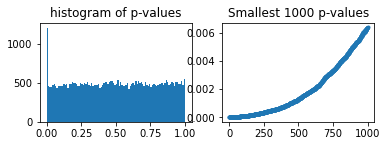

In [5]:
swt = sa.row_welch_tests(grouped_fmri_masked, ObservationsClasses)
p_values=swt['p_value'][:]
p_values_sorted = np.sort(p_values)

plt.subplot(2, 2, 1)
plt.hist(p_values, 100)  #100 bins are used for the histogram
plt.title('histogram of p-values')

 
plt.subplot(2, 2, 2)
plt.plot(p_values_sorted[:1000], '.')
plt.title('Smallest 1000 p-values')

plt.show()

The p-values can also be represented in the image domain. We recall that the voxels that are the most likely to have different values in the compared groups are those with the lowest $p-$values (classically $p-$values<0.05). 

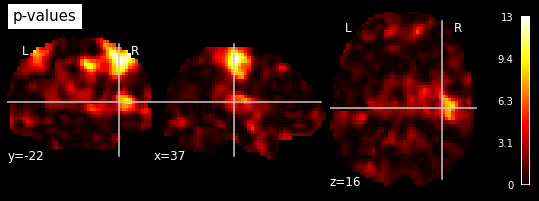

In [6]:

from nilearn.plotting import plot_stat_map
from nilearn import image

p_values_3d=nifti_masker.inverse_transform(-np.log(p_values))
p_values_3d_data=get_data(p_values_3d)

# Visualize statistical p-values using plotting function `plot_stat_map`
mean_img = image.mean_img(contrast_map_filenames_left)


# cut in x-direction
sagittal = 37
# cut in y-direction
coronal = -22
# cut in z-direction
axial = 16

# coordinates displaying should be prepared as a list
cut_coords = [sagittal, coronal, axial]

plot_stat_map(p_values_3d, mean_img,title="p-values", cut_coords=cut_coords)


Remark that we represent here the $-log(p-values)$ and not the $p-values$ directly.


Among all the voxels with values considered as significantly different in the two considered catagories of observations, some of them will be false positives. By construction, rejecting the null hypothesis with a classical p-value of 0.05 at a given voxel indeed means that we are 95% confident that its values are different in the two groups... but in any case that we are absolutely sure that they are different.  

In this context, an important question arises: how handle the fact that we perform many tests to compare simultaneously all (or a subset of) variables representing two categories of observations?

### Post hoc inference

Post hoc inference makes it possible to *build confidence statements on the number of true/false positives within any set $S$ of voxels*: $S$ may be for instance the voxels in a considered cortical region, or alternatively be the set of rejections by a Benjamini-Hochberg (1995) procedure. Multiple choices of $S$ are allowed anyway. 


To calibrate the method with the **sansSouci.python** python package, we first run $B$ times the same tests with permuted observation classes (the labels of "ObservationsClasses");

In [7]:

#Compute the p-values after B permutation

p = grouped_fmri_masked.shape[1]
B = 100

print("Total number of voxels in data set: " + str(p))
print("Number of permutations: " + str(B))

pval0=sa.get_perm_p(grouped_fmri_masked, ObservationsClasses, B=B ,
                    row_test_fun=sa.row_welch_tests)


#Calibrate the method to the data

piv_stat=sa.get_pivotal_stats(pval0, t_inv = sa.t_inv_linear, K=p)

alpha = 0.1
lambda_quant = np.quantile(piv_stat, alpha)
thr = sa.t_linear(lambda_quant, np.arange(1,p+1), p)


Total number of voxels in data set: 48900
Number of permutations: 100


The main output of the calibration is the vector 'thr'. It will be used below to calculate post hoc bounds. Remark that a parameter $\alpha$ has been used for the calibration. It represents a level of certainty with which we will later give bounds on the number of true and false positive voxels found in a pre-defined region. Its intepretation will be made clear in the following examples. 




#### Example 1: Lower bound on the number of voxels associated to the task

We obtain a lower bound on the number of false null hypotheses $p_1$ by using $S$ equal to all $p$ hypotheses; *i.e.* $S$ represents all available variables in the data. With probability $1-\alpha = 0.9$ the number of true null hypotheses should be less than this bound:

In [8]:
bound = p - sa.max_fp(p_values, thr)

print("There are at least " +  str(bound) + " true positives among all " + str(p) + " voxels")

There are at least 331.0 true positives among all 48900 voxels


#### Example 2: Upper bound on the number of false positives among user-selected voxels

We now define a set of voxels of interest, here $S$ represents the 500 voxels associated with the smallest $p$-value). We the calculate the associated post hoc bound on the false positives. 

In [9]:
nb_voxels = 500
pvals=p_values_sorted[:nb_voxels]
pvals

bound = sa.max_fp(pvals, thr)
print("There are at most " +  str(bound) + " false positives among the " + str(nb_voxels) + " most significant voxels")


There are at most 183.0 false positives among the 500 most significant voxels


#### Example 3: Confidence envelopes

We can now compute the lower and upper bounds for various subsets of voxels $S$: We incrementally measure them for the voxels associated with the $i$ smallest $p-$values, with $i$ ranging from $1$ to $1000$.

The input p-values were not sorted -> this is done now


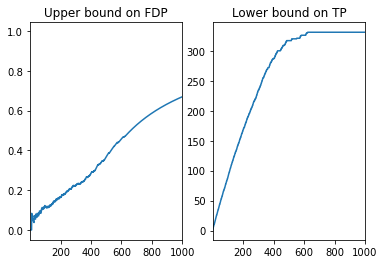

In [10]:
max_FP = sa.curve_max_fp(p_values, thr)

rg = np.arange(1, p+1)
max_FDP = max_FP / rg
min_TP = rg - max_FP
plt.subplot(121)
plt.plot(max_FDP)
plt.title('Upper bound on FDP')
plt.xlim(1, 1000)
plt.subplot(122)
plt.plot(min_TP)
plt.title('Lower bound on TP')
plt.xlim(1, 1000)
plt.show()


#### Example 4: Post hoc inference in a segmented brain region

We can now compute the lower and upper bounds for a subset of voxels $S$ automatically defined by a segmentation algorithm. Here the regions segmented are connected regions of more than 100 voxels with particularly low p-values.

In [11]:
from nilearn import image
from nilearn import regions

one_minus_p_values_3d=nifti_masker.inverse_transform(1-p_values)

img_seuillee = image.threshold_img(one_minus_p_values_3d, threshold='99%', copy=False)

regions_img, index_img= regions.connected_regions(img_seuillee,min_region_size=30)

We represent below the detected regions in different layers of the 3D image, and then the location of the first detected region. The same protocol could also be done for instance in specific cortical regions.

/Users/lrisser/opt/anaconda3/lib/python3.8/site-packages/nilearn/plotting/displays.py:97: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),


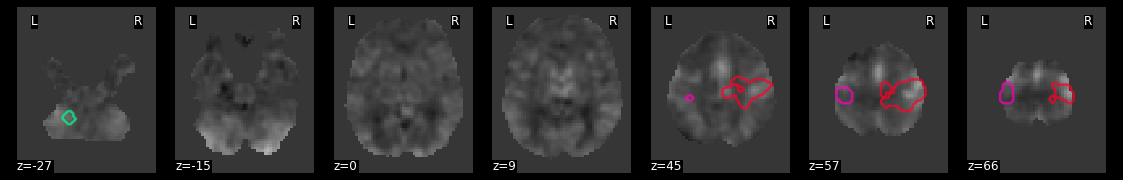

In [12]:
from nilearn import plotting

#plot_stat_map(img_seuillee, mean_img,title="p-values", cut_coords=cut_coords)
plotting.plot_prob_atlas(regions_img, bg_img=mean_img,display_mode='z',cut_coords=7,
                         view_type='contours')

5 regions were detected


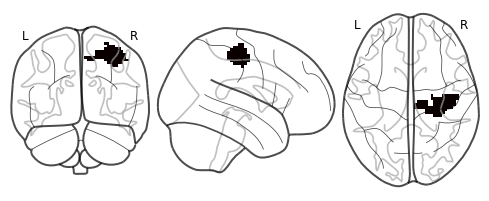

In [13]:
SelectedRegionsProbabilityMaps=nifti_masker.transform(regions_img)

print(SelectedRegionsProbabilityMaps.shape[0],"regions were detected")

ProbaOfBeingInRegion0=SelectedRegionsProbabilityMaps[0]
SegmentedRegion0=ProbaOfBeingInRegion0>0.97


SegmentedRegion0_3D=nifti_masker.inverse_transform(1.*SegmentedRegion0)  #"1.*" transforms booleans into floats 

from nilearn import plotting

plotting.plot_glass_brain(SegmentedRegion0_3D)
                    



Let's check how many true and false positive differences are evaluated in this region.

In [14]:

NbSelectedVoxels=SegmentedRegion0.sum()

bound = sa.max_fp(p_values[SegmentedRegion0], thr)
print("There are at most " +  str(bound) + " false positives among the " + str(NbSelectedVoxels) + " selected significant voxels")


bound = NbSelectedVoxels - sa.max_fp(p_values[SegmentedRegion0], thr)

print("There are at least " +  str(bound) + " true positives among all " + str(NbSelectedVoxels) + " voxels")


There are at most 139.0 false positives among the 233 selected significant voxels
There are at least 94.0 true positives among all 233 voxels


Now the same protocol can be done for the second region.

Maximum probability of being in region 2: 0.46316853   -> very low!
There are at most 20.0 false positives among the 20 selected significant voxels
There are at least 0.0 true positives among all 20 voxels


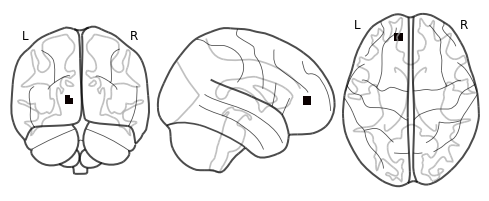

In [15]:

#show the region
ProbaOfBeingInRegion1=SelectedRegionsProbabilityMaps[1]
print("Maximum probability of being in region 2:",ProbaOfBeingInRegion1.max(),"  -> very low!")

SegmentedRegion1=ProbaOfBeingInRegion1>0.10


SegmentedRegion1_3D=nifti_masker.inverse_transform(1.*SegmentedRegion1)  #"1.*" transforms booleans into floats 
plotting.plot_glass_brain(SegmentedRegion1_3D)



#show the bounds

NbSelectedVoxels=SegmentedRegion1.sum()

bound = sa.max_fp(p_values[SegmentedRegion1], thr)
print("There are at most " +  str(bound) + " false positives among the " + str(NbSelectedVoxels) + " selected significant voxels")


bound = NbSelectedVoxels - sa.max_fp(p_values[SegmentedRegion1], thr)

print("There are at least " +  str(bound) + " true positives among all " + str(NbSelectedVoxels) + " voxels")



This region is poorly detected in the probability map. All positive relations are then detected as false positives by the post hoc proceedure!

#### Example 5: Post hoc inference in known brain regions

We finally compute the bounds for a voxel subsets $S$ in known brain regions. We show below a function that  represents the pre-defined brain regions which contain a least one true positive voxel. Note that the images on which the p-values have been computed must be aligned to the atlas containing the brain regions.  


In [16]:
atlas=nilearn.datasets.fetch_atlas_schaefer_2018(n_rois=1000,resolution_mm=1)


In [17]:
print("Total number of labels:")
print(len(atlas.labels))
print("\nFirst labels:")
print(atlas.labels[:20])



Total number of labels:
1000

First labels:
[b'7Networks_LH_Vis_1' b'7Networks_LH_Vis_2' b'7Networks_LH_Vis_3'
 b'7Networks_LH_Vis_4' b'7Networks_LH_Vis_5' b'7Networks_LH_Vis_6'
 b'7Networks_LH_Vis_7' b'7Networks_LH_Vis_8' b'7Networks_LH_Vis_9'
 b'7Networks_LH_Vis_10' b'7Networks_LH_Vis_11' b'7Networks_LH_Vis_12'
 b'7Networks_LH_Vis_13' b'7Networks_LH_Vis_14' b'7Networks_LH_Vis_15'
 b'7Networks_LH_Vis_16' b'7Networks_LH_Vis_17' b'7Networks_LH_Vis_18'
 b'7Networks_LH_Vis_19' b'7Networks_LH_Vis_20']


In [18]:

atlas_masked=nifti_masker_nosmoothing.transform(atlas.maps)

print("Masked atlas shape:")
print(atlas_masked.shape)

am_min=atlas_masked.min()
am_max=atlas_masked.max()

print("Min and max values:",am_min,am_max)



Masked atlas shape:
(1, 48900)
Min and max values: 0.0 1000.0


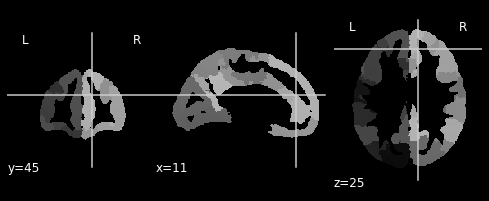

In [19]:
from nilearn.plotting import plot_anat

plot_anat(atlas.maps)

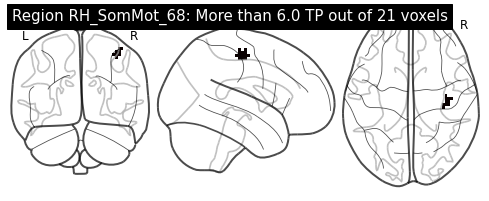

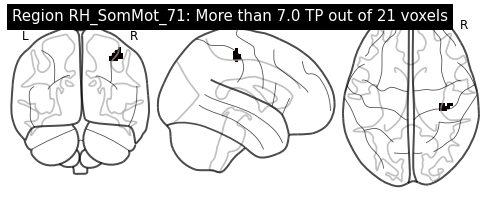

In [20]:
labels=atlas.labels


for cortical_area_ID in range(1,len(labels)):  #label 0 is the background. It is not represented in atlas_masked
      
        #get general information
        curr_label=labels[cortical_area_ID-1]
        ROI=1*(atlas_masked==cortical_area_ID) #atlas_masked[cortical_area_ID-1]
        pvalues_in_ROI=p_values[ np.where(atlas_masked==cortical_area_ID)[1] ]  #the values representing a specific region are not necessarily between 0 and 1 -> normalized
    
        #show the bounds
        NbSelectedVoxels=pvalues_in_ROI.shape[0]

        bound = NbSelectedVoxels - sa.max_fp(pvalues_in_ROI, thr)

        #show the ROI if it has more than 10 voxels and contains more than 25 percents of true positives
        if bound>NbSelectedVoxels*0.25 and NbSelectedVoxels>10:
            ROI_3D=nifti_masker_nosmoothing.inverse_transform(ROI)
            plotting.plot_glass_brain(ROI_3D,title="Region "+str(curr_label[10:].decode("utf-8"))+": More than "+str(bound)+" TP out of "+str(NbSelectedVoxels)+" voxels")
